# Cubic Equations of State

There is one more thing to show of the Python API that `yaeos` supports.
At this point of the tutorial we have been using cubic equations of state
to perform different calculations. The experience users may have noticed
that we never set any interaction parameters for the cubic equations of state.

`yaeos` support the following mixing rules for cubic equations of state:

- QMR: quadratic mixing rule
- MHV: modified Huron-Vidal mixing rule

You can check the available mixing rules by running the following command:

In [18]:
import yaeos

?yaeos.models

Type:        module
String form: <module 'yaeos.models' from '/home/ruther/docs/programming/python/virtualenvs/thermo/lib/python3.13/site-packages/yaeos/models/__init__.py'>
File:        ~/docs/programming/python/virtualenvs/thermo/lib/python3.13/site-packages/yaeos/models/__init__.py
Docstring:  
Models module.

Yaeos models module. This module provides the following submodules:

- excess_gibbs: Excess Gibbs energy models
    - NRTL: non-random two-liquid model
    - UNIFACVLE: Original UNIFAC VLE model
    - UNIQUAC: UNIversal QUAsiChemical Excess Gibbs free energy model

- residual_helmholtz: Residual Helmholtz energy models
    - Cubic EoS:
        - PengRobinson76: Peng-Robinson model (1976)
        - PengRobinson78: Peng-Robinson model (1978)
        - SoaveRedlichKwong: Soave-Redlich-Kwong model
        - RKPR: RKPR model
    - Mixing rules: mixing rules for cubic EoS
        - QMR: cuadratic mixing rule
        - MHV: modified Huron-Vidal mixing rule

## Quadratic mixing rule (QMR)

The QMR is the default mixing rule for all cubic equations of state. But it is
always set with all the interaction parameters equals to zero by default.

To set the $k_{ij}$ and $l_{ij}$ interaction matrix you can do the following:

In [19]:
from yaeos import PengRobinson76, QMR
import numpy as np

tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# binary interaction parameters
kij = np.array([[0.0, 0.1], [0.1, 0.0]])

lij = np.array([[0.0, 0.01], [0.01, 0.0]])

# Set QMR
mixing_rule = QMR(kij=kij, lij=lij)

# Set a model with the QMR with parameters
model_kij = PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule,
)

# Set model without QMR (QMR with all kij and lij as zero)
model = PengRobinson76(tcs, pcs, w)

There we have instantiated a `PengRobinson76` with the QMR mixing rule with
fantasy interaction parameters. And then we instantiated a `PengRobinson76`
with no interaction parameters as we have been doing.

With the model with interaction parameters we can calculate the same things
that we have been calculating at this tutorial. But to show that there is a
difference, we can calculate a phase envelope and see what happens.

Text(0, 0.5, 'Pressure [bar]')

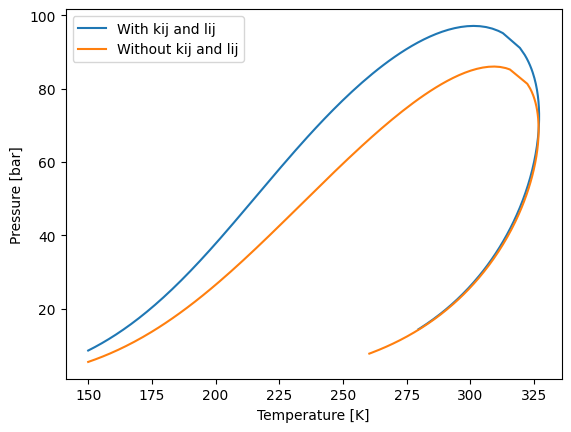

In [20]:
import matplotlib.pyplot as plt

z = np.array([0.5, 0.5])
t0 = 150.0
p0 = 1.0

# Envelope with the model with kij and lij
env_kij = model_kij.phase_envelope_pt(z, t0=t0, p0=p0)

# Envelope with the model without kij and lij
env = model.phase_envelope_pt(z, t0=t0, p0=p0)

# Plot
plt.plot(env_kij["T"], env_kij["P"], label="With kij and lij")
plt.plot(env["T"], env["P"], label="Without kij and lij")

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")

The QMR mix rule can be used with any cubic equation of state that `yaeos`
supports.

## QMR with temperature dependance of $k_{ij}$
It is possible also to give some dependance of temperature to the $k_{ij}$
values, corresponding to the equation:

$$
    k_{ij}(T) = k_{ij}^{\infty} + k_{ij}^{0} \exp{\left(-T/T^{ref}\right)}
$$

In [21]:
from yaeos import QMRTD, PengRobinson76

tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# binary interaction parameters

# Strong repulsions at low temperatures
kij_0 = [[0.0, 0.23], [0.23, 0.0]]

# "attraction" at high temperatures
kij_inf = [[0.0, -0.01], [-0.01, 0.0]]

Tref = [[0.0, 350], [350, 0.0]]
lij = [[0.0, 0.01], [0.01, 0.0]]

# Quadratic mixing rule instance
mixrule = QMRTD(kij_0, kij_inf, Tref, lij)

model_kij_tdep = PengRobinson76(tcs, pcs, w, mixrule)

model_kij_tdep.pressure([0.5, 0.5], 2, 200)

6.959049536037986

Text(0, 0.5, 'Pressure [bar]')

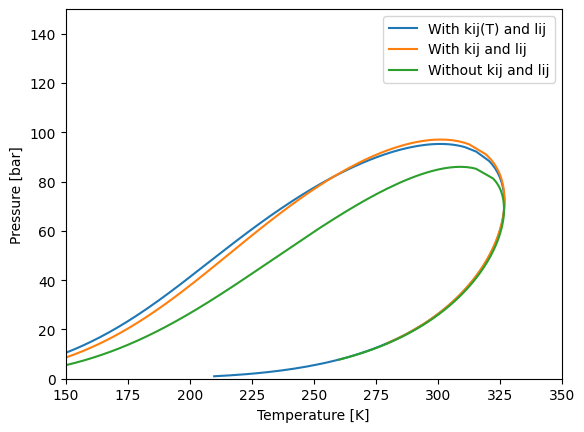

In [22]:
z = np.array([0.5, 0.5])
t0 = 150.0
p0 = 1.0

# Envelope with the model with kij and lij
env_kij_tdep = model_kij_tdep.phase_envelope_pt(z, kind="dew", t0=t0, p0=p0)


# Plot
plt.plot(env_kij_tdep["T"], env_kij_tdep["P"], label="With kij(T) and lij")
plt.plot(env_kij["T"], env_kij["P"], label="With kij and lij")
plt.plot(env["T"], env["P"], label="Without kij and lij")

plt.legend()
plt.xlim(150, 350)
plt.ylim(0, 150)
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")

# Huron-Vidal mixing rule

The Huron-Vidal mixing rule allows linking a Cubic Equation of State with an
Excess Gibbs model, this can be helpful to predict behaviour of systems with
high asymmetry in polarity.

In [23]:
from yaeos import NRTL, HV, PengRobinson76
import numpy as np

tcs = np.array([190.6, 369.8])  # critical temperatures [K]
pcs = np.array([45.99, 42.48])  # critical pressures [bar]
w = np.array([0.0115, 0.0866])  # acentric factors [-]

# binary interaction parameters for NRTL model
aij = np.array([[0.0, -1.2], [0.5, 0.0]])

bij = np.array([[0.0, 100.0], [-100.0, 0.0]])

cij = np.array([[0.0, 0.3], [0.3, 0.0]])

nrtl = NRTL(aij, bij, cij)

mixing_rule = HV(ge=nrtl)

# Set a model with the MHV with parameters
model_hv_nrtl = PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule,
)

## Modified Huron-Vidal mixing rule (MHV)

The other mixing rule that `yaeos` supports is the MHV mixing rule. To use it
we need to instantiate an Excess Gibbs free energy model and pass it to the
MHV mixing rule. The only Excess Gibbs free energy model that `yaeos` supports
is the `NRTL` model. Let's see an example:

In [24]:
from yaeos import NRTL, MHV, PengRobinson76
import numpy as np

mixing_rule = MHV(ge=nrtl, q=-0.53)

# Set a model with the MHV with parameters
model_mhv_nrtl = PengRobinson76(
    critical_temperatures=tcs,
    critical_pressures=pcs,
    acentric_factors=w,
    mixrule=mixing_rule,
)

In [25]:
# Set a model with null kij and lij to compare later
model = PengRobinson76(
    critical_temperatures=tcs, critical_pressures=pcs, acentric_factors=w
)

Let's make first an envelope to see the difference and then explain what is
happening.

(0.0, 150.0)

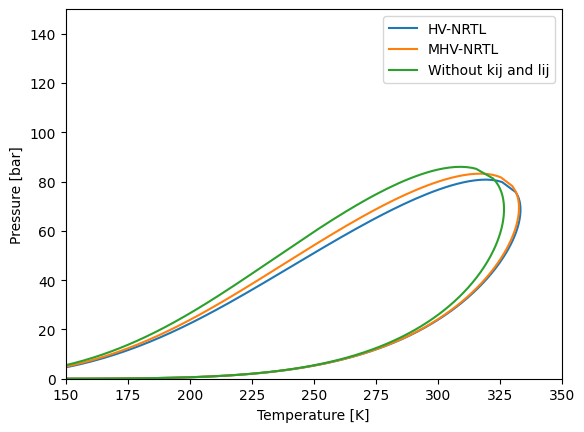

In [26]:
import matplotlib.pyplot as plt

z = np.array([0.5, 0.5])
t0 = 150.0
p0 = 1.0

# Envelope with the model with HV and NRTL
env_mhv_nrtl = model_mhv_nrtl.phase_envelope_pt(
    z, t0=t0, p0=p0, max_points=5000
)

# Envelope with the model with MHV and NRTL
env_hv_nrtl = model_hv_nrtl.phase_envelope_pt(z, t0=t0, p0=p0, max_points=1000)

# Envelope with the model without kij and lij
env = model.phase_envelope_pt(z, t0=t0, p0=p0, max_points=1000)

# Plot
plt.plot(env_hv_nrtl["T"], env_hv_nrtl["P"], label="HV-NRTL")
plt.plot(env_mhv_nrtl["T"], env_mhv_nrtl["P"], label="MHV-NRTL")
plt.plot(env["T"], env["P"], label="Without kij and lij")

plt.legend()
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.xlim(150, 350)
plt.ylim(0, 150)

We have instantiated a `NRTL` model with some interaction parameters and then
instantiated a `MHV` mixing rule with the `NRTL` model. The `q` value of the
`MHV` mixing rule is taken from bibliography. The value to use are:

- q = -0.594 for Soave-Redlich-Kwong
- q = -0.53 for Peng-Robinson
- q = -0.85 for Van der Waals